In [1]:
import xarray as xr

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from scipy import stats

import math

# font size for plots
SMALL_SIZE = 8
BIGGER_SIZE = 12
plt.rc('font', size=  BIGGER_SIZE)
plt.rc('axes', titlesize=BIGGER_SIZE)
plt.rcParams["font.family"] = "serif"


#=================================================================================



ymin = -80.
ymax =  80.
var = 'tang'
ylabel = "Tangential Acceleration"


ymin =   0.
ymax =  80.
var = 'curv'
ylabel = "Curvature Acceleration"



ymin =   0.
ymax =  80.
#speed
var = 'speed'
ylabel = "Translation Speed"

#=================================================================================

mon = '_ASO_'
monTitle = '[August-October]'

mon = '_JAS_'
monTitle = '[July-September]'


mon = '_ALL_'
monTitle = '[All Months]'



mon = '_JASO_'
monTitle = '[July-October]'





mon = '_AS_'
monTitle = '[August-September]'


#=================================================================================

dom = '20_40'
titleString1 = '(b) Atlantic: 20-40N ' + monTitle
titleString2 = '(d) Atlantic: 20-40N ' + monTitle



dom = '20_45'
titleString1 = '(b) Atlantic: 20-45N ' + monTitle
titleString2 = '(d) Atlantic: 20-45N ' + monTitle


dom = '25_45'
titleString1 = '(b) Atlantic: 25-45N ' + monTitle
titleString2 = '(d) Atlantic: 25-45N ' + monTitle





dom = '0_90'
titleString1 = '(a) Entire Atlantic ' + monTitle 
titleString2 = '(b) Entire Atlantic ' + monTitle 

# for JASO
dom = '20_50'
titleString1 = '(c) Atlantic: 20-50N ' + monTitle
titleString2 = '(d) Atlantic: 20-50N ' + monTitle



#for AS
dom = '20_50'
titleString1 = '(e) Atlantic: 20-50N ' + monTitle
titleString2 = '(f) Atlantic: 20-50N ' + monTitle


#=================================================================================
fileName = var+mon + dom+".nc"
output1 = "scatter_" + var+ mon +dom+".png"
output2 = "beta_" + var+ mon +dom+".png"
xlabelString = "Quantiles of Conditional " + ylabel
npfileName = "np_" + var+ mon +dom+".txt"

#fileName = "../dat.nc"
print(fileName)

speed_AS_20_50.nc


In [2]:
#open the data set
ds = xr.open_dataset(fileName)
print(ds)

<xarray.Dataset>
Dimensions:    (ncl0: 1, ncl1: 1, ncl2: 1, ncl3: 1, ncl5: 15206, ncl6: 15206, ncl7: 54, ncl8: 54, storm: 15206)
Dimensions without coordinates: ncl0, ncl1, ncl2, ncl3, ncl5, ncl6, ncl7, ncl8, storm
Data variables:
    startYear  (ncl0) int32 ...
    endYear    (ncl1) int32 ...
    latS       (ncl2) float32 ...
    latN       (ncl3) float32 ...
    Dates      (storm) datetime64[ns] ...
    Data       (ncl5) float64 ...
    Fracyear   (ncl6) float32 ...
    years      (ncl7) float32 ...
    yearly     (ncl8) float64 ...


In [3]:
print(ds.latS)
print(ds.latN)

<xarray.DataArray 'latS' (ncl2: 1)>
array([20.], dtype=float32)
Dimensions without coordinates: ncl2
<xarray.DataArray 'latN' (ncl3: 1)>
array([50.], dtype=float32)
Dimensions without coordinates: ncl3


In [4]:
# now lets read the yearly averaged data and establish some basic trend using OLS = this is the trend of the mean
#
yData  = ds.yearly
years  = ds.years
dfA = pd.DataFrame({'years':years, 'yData':yData, 'const':1})
reg1 = sm.OLS(endog=dfA['yData'], exog=dfA[['const', 'years']],missing='drop')
results = reg1.fit()
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                  yData   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.8268
Date:                Mon, 07 Dec 2020   Prob (F-statistic):              0.367
Time:                        10:42:21   Log-Likelihood:                -154.00
No. Observations:                  54   AIC:                             312.0
Df Residuals:                      52   BIC:                             316.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         88.6723     74.303      1.193      0.2

In [5]:
#plt.plot(years, accel, color='grey',markersize=1)


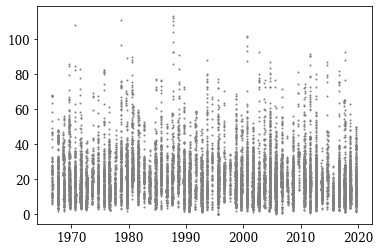

In [6]:

Data  = ds.Data
Time  = ds.Fracyear
plt.plot(Time, Data,'o', color='grey',markersize=1)


In [7]:
# Linear regression using numpy
slope, intercept, r_value, p_value, std_err = stats.linregress(Time.values,Data.values)
print("R-squared : %f" % r_value**2)
print ("slope    : %f" % slope)
print ("p value  : %f" % p_value)
print ("intercept  : %f" % intercept)


R-squared : 0.002011
slope    : -0.036808
p value  : 0.000000
intercept  : 93.940092


In [8]:
# Linear regression using numpy

# the time is in fractional year. What if we just assign all values to an integer year index?
#
xdat = [math.floor(float(i)) for i in Time.values]

slope, intercept, r_value, p_value, std_err = stats.linregress(xdat,Data.values)
print("R-squared : %f" % r_value**2)
print ("slope    : %f" % slope)
print ("p value  : %f" % p_value)
print ("intercept  : %f" % intercept)

#notes: the difference between the previous cell and this is small

R-squared : 0.002006
slope    : -0.036770
p value  : 0.000000
intercept  : 93.839435


In [9]:
# Now on to QR
#
# use the time and data to create a pandas dataframe

df = pd.DataFrame({'Time':Time, 'Data':Data})

#standardize the acceleration values
#df.iloc[:,1:2] = df.iloc[:,1:2].apply(lambda x: (x-x.mean())/ x.std()
#stddev = df.iloc[:,1].std()
#print(stddev)
#df.iloc[:,1] = (df.iloc[:,1]-df.iloc[:,1].mean())/df.iloc[:,1].std()
# we could convert fractional year to just year by using the xdat that was created using the floor function
# i.e. all points in a year (e.g. 2001) will be assigned the time = 2001.
#df = pd.DataFrame({'Time':xdat, 'Data':Data})

# Notes: I tested the outcome of keeping the fractional year versus the integer year (floor). The differences were minute
# so, either should be fine

#print(df.iloc[:,1].mean())
#print(df.iloc[:,1].std())



In [10]:
# A frst order polynomial fit to get the linear regression
poly = smf.ols(formula='Data ~ 1 +  Time', data=df).fit()
print (poly.summary())


                            OLS Regression Results                            
Dep. Variable:                   Data   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     30.63
Date:                Mon, 07 Dec 2020   Prob (F-statistic):           3.17e-08
Time:                        10:42:21   Log-Likelihood:                -60568.
No. Observations:               15206   AIC:                         1.211e+05
Df Residuals:                   15204   BIC:                         1.212e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     93.9401     13.261      7.084      0.0

In [11]:
mod = smf.quantreg('Data ~ Time', df)
result = mod.fit(q=.50)
print(result.summary())
#print (dir(res))

print(result.pvalues['Time'])
print(result.params['Time'])

                         QuantReg Regression Results                          
Dep. Variable:                   Data   Pseudo R-squared:             0.002019
Model:                       QuantReg   Bandwidth:                       2.095
Method:                 Least Squares   Sparsity:                        24.17
Date:                Mon, 07 Dec 2020   No. Observations:                15206
Time:                        10:42:21   Df Residuals:                    15204
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    102.3988     12.334      8.302      0.000      78.222     126.576
Time          -0.0422      0.006     -6.825      0.000      -0.054      -0.030

The condition number is large, 2.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.


In [12]:
#quantiles = np.arange(.05,.96, .05)

quantiles = [0.05,.10,.15,.2,.3,.5,.7,.8,.85,.90,.95]


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'],res.params['Time'], res.pvalues['Time']] + \
            res.conf_int().loc['Time'].tolist()
   
        
models = [fit_model(x1) for x1 in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'p', 'lb', 'ub'])
np.savetxt(npfileName, models[["q","b","p","lb","ub"]], fmt='%1.2f & %1.3f & %1.3f &  [ %1.3f, %1.3f ] \\')


In [13]:
quantiles = np.arange(.05,.96, .05)

#quantiles = [0.05,.10,.15,.2,.5,.7,.8,.85,.90,.95]


def fit_model(q):
    res = mod.fit(q=q)
    return [q, res.params['Intercept'],res.params['Time'], res.pvalues['Time']] + \
            res.conf_int().loc['Time'].tolist()
   
        
models = [fit_model(x1) for x1 in quantiles]
models = pd.DataFrame(models, columns=['q', 'a', 'b', 'p', 'lb', 'ub'])

print(models.round(4))


       q         a       b       p      lb      ub
0   0.05   40.6765 -0.0177  0.0004 -0.0276 -0.0078
1   0.10   29.2410 -0.0111  0.0352 -0.0214 -0.0008
2   0.15    9.7116 -0.0005  0.9276 -0.0119  0.0108
3   0.20   14.5979 -0.0022  0.7276 -0.0148  0.0103
4   0.25   39.3101 -0.0139  0.0326 -0.0266 -0.0011
5   0.30   44.8023 -0.0159  0.0140 -0.0286 -0.0032
6   0.35   71.0306 -0.0284  0.0000 -0.0417 -0.0152
7   0.40   86.8512 -0.0357  0.0000 -0.0488 -0.0225
8   0.45   95.6791 -0.0394  0.0000 -0.0519 -0.0270
9   0.50  102.3988 -0.0422  0.0000 -0.0543 -0.0301
10  0.55  103.7116 -0.0423  0.0000 -0.0546 -0.0299
11  0.60   99.8156 -0.0397  0.0000 -0.0528 -0.0265
12  0.65  106.2645 -0.0422  0.0000 -0.0570 -0.0273
13  0.70  107.9849 -0.0422  0.0000 -0.0590 -0.0253
14  0.75  105.0050 -0.0396  0.0001 -0.0592 -0.0201
15  0.80  169.0552 -0.0704  0.0000 -0.0907 -0.0501
16  0.85  217.4743 -0.0933  0.0000 -0.1152 -0.0713
17  0.90  220.6401 -0.0928  0.0000 -0.1290 -0.0566
18  0.95  206.6780 -0.0808  0.0

In [14]:
# Least square estimate of the trend of the mean

ols = smf.ols(formula='Data ~ Time', data=df).fit()
ols_ci = ols.conf_int().loc['Time'].tolist()
ols = dict(a = ols.params['Intercept'],
           b = ols.params['Time'],
           lb = ols_ci[0],
           ub = ols_ci[1],
           p=ols.pvalues['Time'])
print(ols)


{'a': 93.94008902856989, 'b': -0.0368076138702329, 'lb': -0.049842752162436006, 'ub': -0.0237724755780298, 'p': 3.166736149577617e-08}


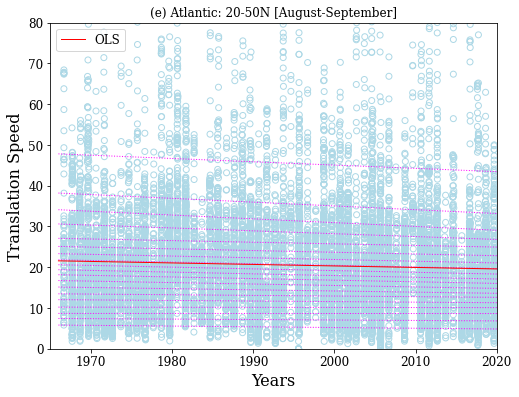

In [15]:
#x = np.arange(df.years.min(), df.years.max(), 50)

x = np.arange(1966,2021,1)

get_y = lambda a, b: a + b * x

n = 9
colors = pl.cm.jet(np.linspace(0,1,n))

fig, ax = plt.subplots(figsize=(8, 6))

for i in range(models.shape[0]):
    y = get_y(models.a[i], models.b[i])
    ax.plot(x, y, linestyle='dotted', linewidth=1, color='magenta')    
    
y = get_y(ols['a'], ols['b'])



ecolor = "lightblue"
ax.scatter(df.Time, df.Data, facecolors='none', edgecolors=ecolor) #, s=2 ,alpha=.7)
ax.plot(x, y, color='red', linewidth=1, label='OLS')
ax.set_xlim((1965,2020))
ax.set_ylim((ymin,ymax))
legend = ax.legend()
ax.set_xlabel('Years', fontsize=16)
ax.set_ylabel(ylabel, fontsize=16);
plt.title(titleString1)

plt.savefig(output1)


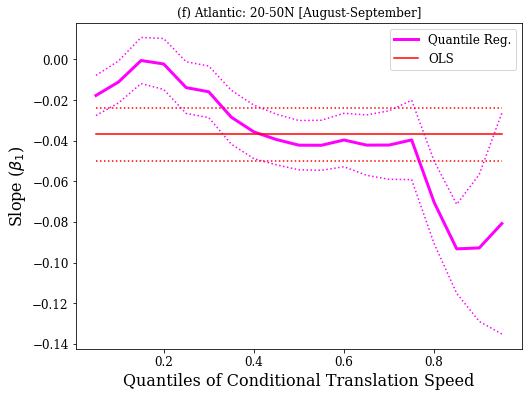

In [16]:
n = models.shape[0]
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(models.q, models.b,     color='magenta', linewidth=3, label='Quantile Reg.')
ax.plot(models.q, models.ub, linestyle='dotted', color='magenta')
ax.plot(models.q, models.lb, linestyle='dotted', color='magenta')

ax.plot(models.q, [ols['b']] * n, color='red', label='OLS')
ax.plot(models.q, [ols['lb']] * n, linestyle='dotted', color='red')
ax.plot(models.q, [ols['ub']] * n, linestyle='dotted', color='red')
legend = ax.legend()
ax.set_xlabel(xlabelString, fontsize=16)
ax.set_ylabel('Slope (' + r'$\beta_1$' +')', fontsize=16);
plt.title(titleString2)

plt.savefig(output2)


In [17]:
inter = 367.7540
slope = -0.1639

ydat = inter + slope*2019
print (ydat)

36.83990000000006
